In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 200
HIDDEN_CHANNELS = 7

def build_preparation_network():
    return models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(50, 4, padding='same', activation='relu'),
        layers.Conv2D(50, 4, padding='same', activation='relu'),
        layers.Conv2D(50, 4, padding='same', activation='relu'),
        layers.Conv2D(30, 2, padding='same', activation='relu'),
        layers.Conv2D(HIDDEN_CHANNELS, 2, padding='same', activation='tanh'),
    ])

def build_hiding_network():
    host_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    hidden_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, HIDDEN_CHANNELS))
    x = layers.Concatenate()([host_input, hidden_input])
    for _ in range(4):
        x = layers.Conv2D(50, 4, padding='same', activation='relu')(x)
    x = layers.Conv2D(30, 2, padding='same', activation='relu')(x)
    out = layers.Conv2D(3, 2, padding='same', activation='tanh')(x)
    return models.Model([host_input, hidden_input], out)

def build_reveal_network():
    return models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(100, 4, padding='same', activation='relu'),
        layers.Conv2D(100, 4, padding='same', activation='relu'),
        layers.Conv2D(50, 4, padding='same', activation='relu'),
        layers.Conv2D(3, 2, padding='same', activation='tanh'),
    ])

def build_full_model():
    prep = build_preparation_network()
    hide = build_hiding_network()
    reveal = build_reveal_network()

    host_in = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    hidden_in = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    prep_out = prep(hidden_in)
    container = hide([host_in, prep_out])
    revealed = reveal(container)

    return models.Model([host_in, hidden_in], [container, revealed])

# Instantiate
model = build_full_model()
model.compile(optimizer='adam', loss='mse')  # 可替換為加權 loss
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 200, 200,  │     89,427 │ input_layer_17[0… │
│ (Sequential)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 200, 200,  │    134,593 │ input_layer_16[0… │
│ (Functional)        │ 3)                │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 200, 200,  │    245,653 │ functional_9[0][… │
│ (Sequential)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 469,673 (1.79 MB)

 Trainable params: 469,673 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
import tensorflow as tf

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [200, 200])
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Scale to [-1, 1]
    return image

# 假設你有 host 和 hidden 圖像的路徑
# 更正：提供實際圖像文件的路徑，而不是資料夾路徑
host_image = preprocess_image('/content/hidden_imgs/hd.jpg')
hidden_image = preprocess_image('/content/host_imgs/th.jpg')

# 組成一組樣本並加上 batch 維度
host_image = tf.expand_dims(host_image, 0)    # shape: (1, 200, 200, 3)
hidden_image = tf.expand_dims(hidden_image, 0)


In [36]:
y_true = [host_image, hidden_image]

In [37]:
model.fit([host_image, hidden_image], [host_image, hidden_image], epochs=50, batch_size=32)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - functional_9_loss: 0.4791 - loss: 1.1397 - sequential_5_loss: 0.6606
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - functional_9_loss: 0.4323 - loss: 1.0627 - sequential_5_loss: 0.6304
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - functional_9_loss: 0.3530 - loss: 0.8421 - sequential_5_loss: 0.4891
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - functional_9_loss: 0.2596 - loss: 0.5372 - sequential_5_loss: 0.2776
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - functional_9_loss: 0.1674 - loss: 0.4567 - sequential_5_loss: 0.2892
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - functional_9_loss: 0.1283 - loss: 0.4291 - sequential_5_loss: 0.3008
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - functional_9_loss: 0.0892 - loss: 0.3801 - sequential_5_loss: 0.2909
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - functional_9_loss: 0.1099 - loss: 0.3676 - sequential_5_loss: 0.2578
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - funct

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# 將 [-1, 1] 的影像轉換回 [0, 1]，以便於顯示
def denormalize(image):
    return (image + 1.0) / 2.0

# 推論並顯示結果
def show_predictions(model, host_image, hidden_image):
    # 加 batch 維度
    host_batch = tf.expand_dims(host_image, axis=0)
    hidden_batch = tf.expand_dims(hidden_image, axis=0)

    # 推論 - model.predict returns NumPy arrays
    container_image, revealed_image = model.predict([host_batch, hidden_batch])

    # 去除 batch 維度，並轉換成可視化範圍
    # container_image and revealed_image are already NumPy arrays,
    # so remove the .numpy() call
    host = denormalize(host_image).numpy() # host_image is a Tensor from the Dataset
    hidden = denormalize(hidden_image).numpy() # hidden_image is a Tensor from the Dataset
    container = denormalize(container_image[0]) # container_image[0] is already a NumPy array
    revealed = denormalize(revealed_image[0]) # revealed_image[0] is already a NumPy array

    # 顯示圖像
    titles = ['Host Image', 'Hidden Image', 'Container Image', 'Revealed Hidden']
    images = [host, hidden, container, revealed]

    plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        # Ensure images are within the displayable range [0, 1]
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

IMG_SIZE = 200

def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    # Try decoding as both jpeg and png in case there's a mix of file types
    try:
        image = tf.image.decode_jpeg(image, channels=3)
    except tf.errors.InvalidArgumentError:
        image = tf.image.decode_png(image, channels=3)

    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image

def load_image_pair(host_path, hidden_path):
    host_image = preprocess_image(host_path)
    hidden_image = preprocess_image(hidden_path)
    # Return the input and output structure as expected by the model
    return (host_image, hidden_image), (host_image, hidden_image)

def create_dataset(host_dir, hidden_dir, batch_size=32, shuffle=True):
    # Ensure the paths provided are actually directories
    if not os.path.isdir(host_dir):
        raise ValueError(f"'{host_dir}' is not a valid directory path.")
    if not os.path.isdir(hidden_dir):
        raise ValueError(f"'{hidden_dir}' is not a valid directory path.")

    host_files = sorted([os.path.join(host_dir, f) for f in os.listdir(host_dir) if f.endswith(('.jpg', '.png'))])
    hidden_files = sorted([os.path.join(hidden_dir, f) for f in os.listdir(hidden_dir) if f.endswith(('.jpg', '.png'))])

    if len(host_files) != len(hidden_files):
        raise ValueError("Host and hidden image folders must contain the same number of images.")

    # Create a dataset of tuples of file paths
    filepath_ds = tf.data.Dataset.from_tensor_slices((host_files, hidden_files))

    # Map the loading and preprocessing function over the dataset of file paths
    dataset = filepath_ds.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(host_files))

    # Batch and prefetch
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [47]:
host_dir = "/content/host_imgs"         # 你的宿主圖像資料夾
hidden_dir = "/content/hidden_imgs"     # 你的欲藏圖像資料夾
train_dataset = create_dataset(host_dir, hidden_dir, batch_size=32, shuffle=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


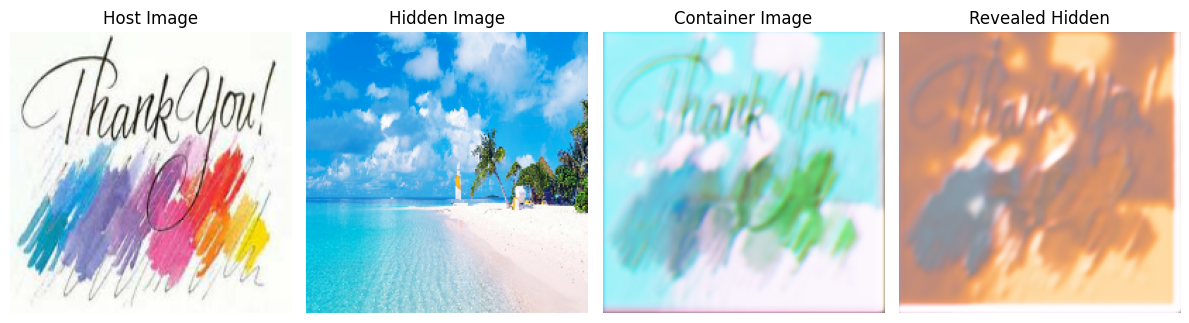

In [54]:
for (host_batch, hidden_batch), _ in train_dataset.take(1):
    host_img = host_batch[0]
    hidden_img = hidden_batch[0]

show_predictions(model, host_img, hidden_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


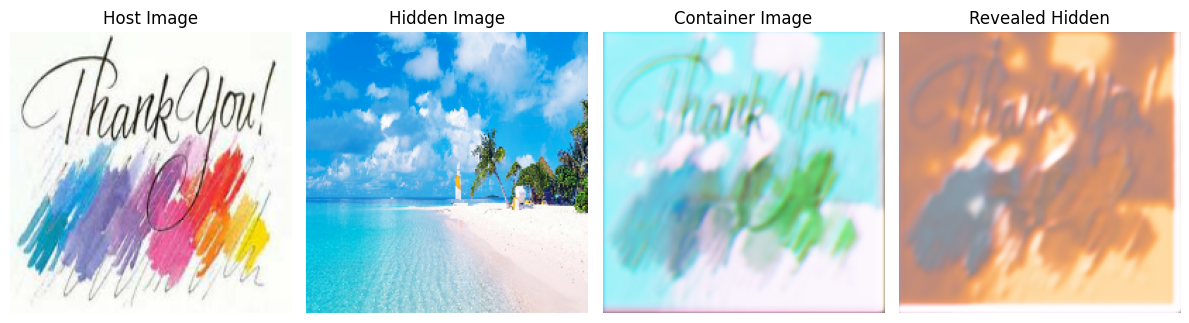

In [55]:
# 假設從 Dataset 中取得一個 batch
for (host_batch, hidden_batch), _ in train_dataset.take(1):
    host_img = host_batch[0]
    hidden_img = hidden_batch[0]

show_predictions(model, host_img, hidden_img)